Total labels 33 
Total train images 16854
Total Test images 5641
(16854, 100, 100, 3)
(5641, 100, 100, 3)
{'Apple Braeburn': 491, 'Apple Granny Smith': 983, 'Apricot': 1475, 'Avocado': 1902, 'Banana': 2392, 'Blueberry': 2854, 'Cactus fruit': 3344, 'Cantaloupe': 3836, 'Cherry': 4328, 'Clementine': 4818, 'Corn': 5268, 'Cucumber Ripe': 5660, 'Grape Blue': 6644, 'Kiwi': 7110, 'Lemon': 7602, 'Limes': 8092, 'Mango': 8582, 'Onion White': 9020, 'Orange': 9499, 'Papaya': 9991, 'Passion Fruit': 10481, 'Peach': 10973, 'Pear': 11669, 'Pepper Green': 12113, 'Pepper Red': 12779, 'Pineapple': 13269, 'Plum': 13716, 'Pomegranate': 14208, 'Potato Red': 14658, 'Raspberry': 15148, 'Strawberry': 15640, 'Tomato': 16378, 'Watermelon': 16853}
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
(13483, 100, 100, 3)
(3371, 100, 100, 3)
(128, 100, 100, 3) (128, 16854)
(128, 100, 100, 3) (128, 16854)
(128, 100, 100, 3)
Epoch : 0 loss : 1.08085179

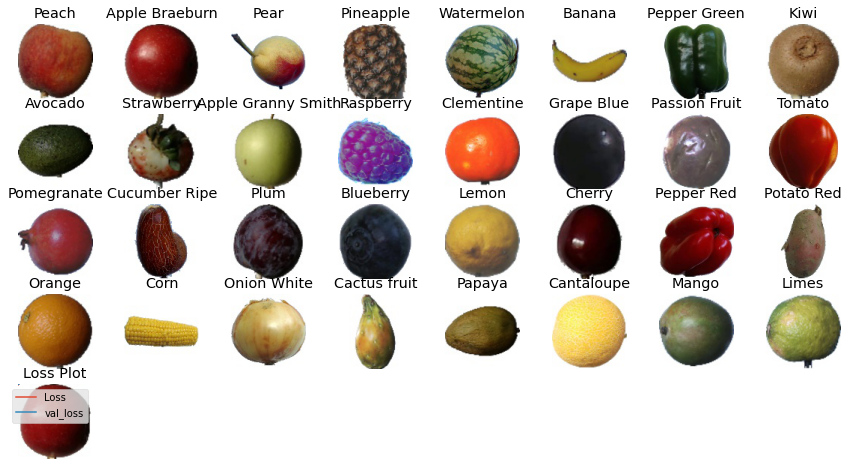

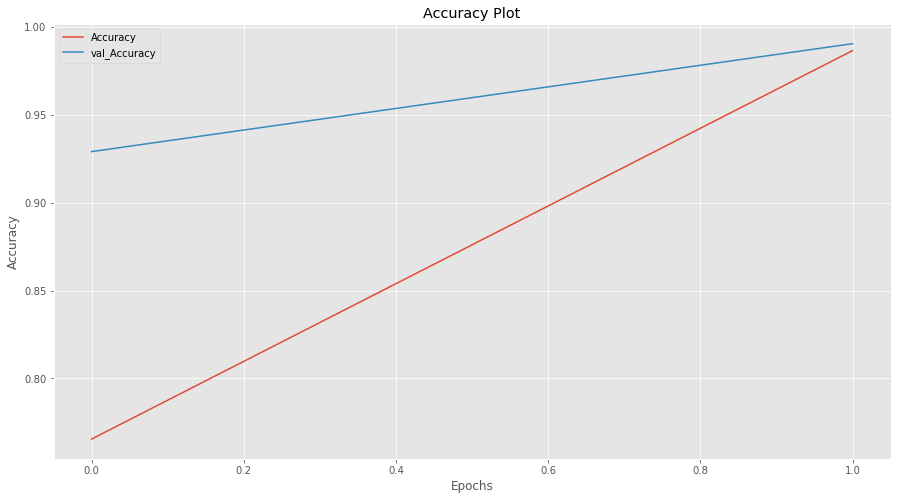

In [4]:

#%%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
import tensorflow as tf
import random
import re as regex
import pathlib

from sklearn.model_selection import train_test_split
from tensorflow import keras
from PIL import Image
from typing import List, Dict, Tuple, Set
from keras.utils import load_img, img_to_array

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,8)
#%%
########################################################################
################################################################################
# Coded by  : Rose ( Pratama Azmi A)
# Date : 26/02/2023
# Text Editor : Vscode + Vim
# Sorry if the output is only on one cell, since i used .py when doing datascience 
################################################################################
########################################################################

#%%


class callbackForSure(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        print("Epoch : %s loss : %s , val loss : %s" %(epoch, logs["loss"] , logs["val_loss"]))
        print("Accuracy : %s, val Accuracy : %s" %( logs["accuracy"] , logs["val_accuracy"]))
        print()

        if(logs["accuracy"] > 0.92 and logs["val_accuracy"] > 0.92):
            self.model.stop_training = True
            print("reach the 90% Accuracy, Stopping training")
    

def getFolderInformation(folderName : str)-> Tuple[List[str], List[str], List[str]]:
    
    
    listOfImagesTrain : List[str] = []
    listOfImagesValidation : List[str] = []
    listOfLabels : List[str] = []
    for folder in os.listdir(folderName):
        
        if(os.path.isdir(os.path.join(folderName,folder))):
            for subFolder in os.listdir(os.path.join(folderName,folder)):
                if(folder == "train"):
                    listOfLabels.append(subFolder)
                    for subFolderContent in os.listdir(os.path.join(folderName, folder, subFolder)):
                        listOfImagesTrain.append(subFolderContent)
                elif(folder=="test"):
                    listOfImagesValidation.append(subFolder)
        
    listOfLabels = list(set(listOfLabels))
    print("Total labels %s "% (len(listOfLabels)))
    print("Total train images %s" % (len(listOfImagesTrain)))
    print("Total Test images %s" %(len(listOfImagesValidation)))

    return listOfLabels, listOfImagesTrain, listOfImagesValidation


def visualizeImagesRandomly(label : str, filesDir :str)  -> None:
        fileNameGenerated : str = random.sample(os.listdir(os.path.join(filesDir, label)),1)[0]
        filePath : str = os.path.join(filesDir, label, fileNameGenerated)
        img =plt.imread(filePath)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

def createDataFrame(path : str , isValidation : bool = False):
         
    dataFrameRaw : Dict[str,List[str]] = {
         "path" : [],
         "fileName" : [],
    }
    if(not isValidation):
        dataFrameRaw["label"] = []
        for dirpath, dirNames, fileNames in os.walk(path):
            for fileName in fileNames:
                dataFrameRaw["path"].append(dirpath)
                dataFrameRaw["fileName"].append(fileName)
                dataFrameRaw["label"].append(fileName.split("_")[0]) #Watermellon_0 as an example
    else :
        for dirpath, dirNames, fileNames in os.walk(path):
            for fileName in fileNames:
                dataFrameRaw["path"].append(dirpath)
                dataFrameRaw["fileName"].append(fileName)
    return dataFrameRaw

def prepareNpDataset(df : pd.DataFrame, isValidation : bool = False) -> Tuple[np.array,
                                                                              np.array]:
    images : List[Image.Image] = []
    labels : List[str] = []
    if( not isValidation):
        for _, im in df.iterrows():
            img : Image.Image = preprocessTheImage(load_img(os.path.join(im["path"], im["fileName"])))
            images.append(img)
            labels.append(im["label"])

        return np.array(images), np.array(labels)
    else :
        for _, im in df.iterrows():
            img : Image.Image = preprocessTheImage(load_img(os.path.join(im["path"], im["fileName"])))
            images.append(img)

        return np.array(images)
    

def preprocessTheImage(img : Image.Image) -> Image.Image:
    img = img.resize((100,100)) ## Resizing so every image at same size
    img = img_to_array(img)
    img /= 255 # Normalize ( 0 - 1)
    return img

def showImage(img : Image.Image) -> None:
    plt.imshow(img)
    plt.axis("off")

def splitTraining(np_train : np.array, labels : np.array,size : float=0.2) -> Tuple[np.array, np.array, np.array, np.array]:
    x_train,x_val,y_train,y_val = train_test_split(np_train, labels, test_size=size, random_state=3)
    return x_train,x_val,y_train,y_val

def prepareTensorDataset(np_train : np.array, np_train_y : np.array,
                          np_validation : np.array, np_validation_y :np.array,
                          np_test : np.array) -> Tuple[tf.data.Dataset,
                                                                                                     tf.data.Dataset,
                                                                                                     tf.data.Dataset]:
    ds_train : tf.data.Dataset = tf.data.Dataset.from_tensor_slices((np_train, np_train_y))
    ds_validation : tf.data.Dataset = tf.data.Dataset.from_tensor_slices((np_validation, np_validation_y))
    ds_test : tf.data.Dataset = tf.data.Dataset.from_tensor_slices(np_test)

    return ds_train, ds_validation, ds_test


def prepareForModelling(ds : tf.data.Dataset, Batch_size : int = 128 ,shuffle: bool  = True,):
    AUTOTUNE = tf.data.AUTOTUNE
    if shuffle:
        ds = ds.shuffle(1000)
    
    ds = ds.batch(Batch_size)
    
    return ds.prefetch(buffer_size=AUTOTUNE)

def prepareModel() -> tf.keras.Sequential:

    model : tf.keras.Sequential = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=5,
        kernel_size=3,
        activation = tf.nn.relu,
        input_shape=(100,100,3)
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=len(np_labels), activation=tf.nn.softmax))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(name="loss"), 
        metrics = [
            tf.keras.metrics.CategoricalAccuracy(name="accuracy")
        ]
    )

    return model

def convertClassNamesToLabels(classNames : List[str], labels : List[str]) -> np.array:
    class_indices = dict(zip(labels, range(len(labels))))
    print(class_indices)

    labels_encoded = list(map(class_indices.get, labels))

    label_categorical : np.array = tf.keras.utils.to_categorical(labels_encoded, num_classes=len(labels), dtype="uint8")
    return label_categorical

def plotHistory(history : dict, isLoss : bool = False) -> None:
    if(isLoss):
        plt.plot(history.history["loss"])
        plt.plot(history.history["val_loss"])
        plt.title("Loss Plot")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["Loss","val_loss"])
        plt.show()
    elif(not isLoss):

        plt.plot(history.history["accuracy"])
        plt.plot(history.history["val_accuracy"])
        plt.title("Accuracy Plot")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend(["Accuracy","val_Accuracy"])
        plt.show()
# %%
trainPath : str = "./data/train/"
testPath : str="./data/test"
listOfLabels, listOfImagesTrain, listOfImagesTest = getFolderInformation("./data")
data_dir = pathlib.Path(trainPath)
classNames : List[str] = np.array(sorted([item.name for item in data_dir.glob("*")])) #Get all classnames
for indx, label in enumerate(listOfLabels) :
     plt.subplot(5, 8, indx+1)
     visualizeImagesRandomly(label, "./data/train/")

df_train : pd.DataFrame = pd.DataFrame(createDataFrame(trainPath))
df_test :pd.DataFrame = pd.DataFrame(createDataFrame(testPath,True))


#%%
# Prepare the numpy array to be used for spliting training
np_train, np_labels = prepareNpDataset(df_train)
np_test = prepareNpDataset(df_test,True)

#%% Check shape of the data
print(np_train.shape)
print(np_test.shape)
showImage(np_train[0])


#%% CONVERT THE CLASS to labels
np_labels = convertClassNamesToLabels(classNames, np_labels)
print(np_labels)
#%%
### ###### Split the dataset
x_train,x_val,y_train,y_val = splitTraining(np_train,np_labels)
print(x_train.shape)
print(x_val.shape)
#%% 
#### #### Preparing dataset using tf.data.Dataset
ds_train, ds_val, ds_test = prepareTensorDataset(x_train,y_train,
                                                 x_val,y_val,np_test)
ds_train = prepareForModelling(ds_train)
ds_val = prepareForModelling(ds_val,)
ds_test = prepareForModelling(ds_test)

#%%
## Assure the shape
ds_train_im, ds_train_label = next(ds_train.as_numpy_iterator())
ds_validation_im, ds_validation_label = next(ds_val.as_numpy_iterator())
ds_test_im = next(ds_train.as_numpy_iterator())

print(ds_train_im.shape, ds_train_label.shape)
print(ds_validation_im.shape, ds_validation_label.shape)
print(ds_test_im[0].shape)

#%%
## Get the model
model :tf.keras.Sequential = prepareModel()


#%%
## Train the model
history = model.fit(ds_train, validation_data=ds_val, epochs=5, callbacks=[callbackForSure()], verbose=0)
#%%

plotHistory(history, isLoss=True)
plotHistory(history, isLoss=False)
# %%


In [5]:
# Save model
model.save("modelAns.h5")

In [8]:
## Tflite 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile("modelAns.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp8edroe9c\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp8edroe9c\assets
